In [18]:
# warnings....ignore
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

pd.options.mode.chained_assignment = None

In [19]:
DATA = []
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2, 5, 10]
TIME_VECTOR = 5  # second

In [20]:
import json


def get_data_from_file(filename: str):
    f = open(filename, "r")
    while True:
        line = f.readline()
        if not line:
            break
        # Standardize json to dict
        row = json.loads(line)
        # Append to Array
        DATA.append(row)

In [21]:
get_data_from_file("../statics/request_data_with_anomaly_pod_instance.json")

In [22]:
group_by_el = ["path", "method", "service_name", "controller_pod"]

In [23]:
# Create dataframe
root_df = pd.DataFrame(DATA)

In [24]:
root_df.head()

,timestamp,path,method,service_name,controller_pod,duration_time
0,"01/02/2024, 10:42:25",/users,GET,process_log,pod-2,0.395
1,"01/02/2024, 10:42:26",/users,GET,process_log,pod-2,0.669
2,"01/02/2024, 10:42:26",/home,GET,process_log,pod-2,0.511
3,"01/02/2024, 10:42:26",/users,GET,process_log,pod-2,0.439
4,"01/02/2024, 10:42:27",/home,GET,process_log,pod-1,0.236


In [25]:
# Bins data to bucket latency
def bucketing(duration_time):
    res = []
    for bucket in BUCKETS:
        if duration_time <= bucket:
            res.append(bucket)
    res.append("+Inf")
    return res

root_df["le"] = root_df["duration_time"].apply(lambda x: bucketing(x))

In [26]:
root_df.query("path == '/users' and controller_pod == 'pod-1'")['le']

5                        [1, 2, 5, 10, +Inf]
6        [0.1, 0.25, 0.5, 1, 2, 5, 10, +Inf]
8                        [1, 2, 5, 10, +Inf]
9             [0.25, 0.5, 1, 2, 5, 10, +Inf]
10                  [0.5, 1, 2, 5, 10, +Inf]
                        ...                 
35234         [0.25, 0.5, 1, 2, 5, 10, +Inf]
35236                    [1, 2, 5, 10, +Inf]
35237               [0.5, 1, 2, 5, 10, +Inf]
35241         [0.25, 0.5, 1, 2, 5, 10, +Inf]
35245         [0.25, 0.5, 1, 2, 5, 10, +Inf]
Name: le, Length: 8847, dtype: object

In [27]:
group_dataset = root_df.groupby(group_by_el).count().reset_index()[group_by_el]

In [28]:
group_dataset

,path,method,service_name,controller_pod
0,/home,GET,process_log,pod-1
1,/home,GET,process_log,pod-2
2,/users,GET,process_log,pod-1
3,/users,GET,process_log,pod-2


In [29]:
from typing import Dict


def bins_value(row, bins_dict: Dict):
    # unwind data from list
    list_le = row['le']
    for le in list_le:
        if le in bins_dict:
            bins_dict[le] += 1
    bins_series = pd.Series(
        data=bins_dict, index=bins_dict.keys()  # type: ignore
    )
    # Join two series
    new_row = pd.concat([row, bins_series])
    return new_row

In [30]:
# Bins value to bucket latency
df_by_group = {}
for idx, dataset in group_dataset.iterrows():
    bins_dict = {k: 0 for k in BUCKETS}
    bins_dict['+Inf'] = 0  # type: ignore
    # Query for each group get dataframe and save it to datastructure
    df_by_group[idx] = root_df.query(
        "path == @dataset['path'] \
                and method == @dataset['method'] \
                and service_name == @dataset['service_name'] \
                and controller_pod == @dataset['controller_pod']") \
        .apply(lambda x: bins_value(x, bins_dict), axis=1)

# Join all group dataframe processed by one dataframe
df_by_group_incl_latency = pd.concat(df_by_group.values())

In [31]:
from datetime import datetime

df_by_group_incl_latency['timestamp'] = df_by_group_incl_latency['timestamp'].apply(
    lambda x: datetime.strptime(x, "%d/%m/%Y, %H:%M:%S"))
# Convert to datetime pandas and set datetime columns is index for dataframe
df_by_group_incl_latency['timestamp'] = pd.to_datetime(root_df['timestamp'])
df_by_group_incl_latency = df_by_group_incl_latency.set_index('timestamp')

In [32]:
df_by_group_incl_latency.rename(columns={v: str(v) for v in BUCKETS}, inplace=True)

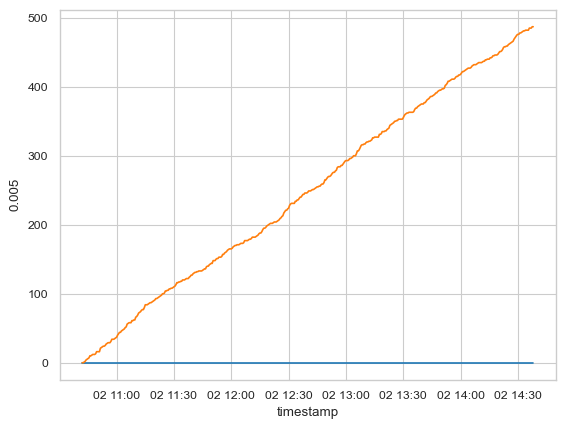

In [33]:
data = df_by_group_incl_latency.groupby([pd.Grouper(freq="30s")] + group_by_el).agg({str(el): "last" for el in BUCKETS + ["+Inf"]}).query("path == '/home' and controller_pod == 'pod-2'").reset_index().set_index('timestamp')
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("paper")
# sns.lineplot(data=data, x="timestamp", y="+Inf")
sns.lineplot(data=data, x="timestamp", y="0.005")
sns.lineplot(data=data, x="timestamp", y="0.05")
plt.show()

In [34]:
df_by_group_incl_latency.groupby([pd.Grouper(freq="30s")] + group_by_el).agg({str(el): "last" for el in BUCKETS + ["+Inf"]}).reset_index().set_index('timestamp').to_csv("request_data_with_anomaly_pod_instance.csv")